In [1]:
#import all libraries needed
import spacy
import json
from spacy import displacy
from sklearn.model_selection import train_test_split
from spacy.tokens import DocBin
from tqdm import tqdm
from spacy.util import filter_spans
from spacy.training import Example
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#create a blank spaCy model for german language
nlp = spacy.blank("de")
#initialize a DocBin object
doc_bin = DocBin()

In [3]:
#open the medical NER dataset
with open ('/content/GERNERMED_dataset.json','r') as f:
  data = json.load(f)

In [4]:
#create train and test sets
data_de = []
for item in data:
  temp_dict = {}
  temp_dict['text'] = item['de']
  temp_dict['entities'] = []
  for annotation in item['annotations']:
    start = annotation['de_spans'][0]
    end = annotation['de_spans'][1]
    label = annotation['type']
    temp_dict['entities'].append((start, end, label))
  data_de.append(temp_dict)

train_data, test_data = train_test_split(data_de, test_size=0.2, random_state=42)

In [ ]:
#process training data for NER and save the processed documents in a binary format for training a spaCy NER model
for training_example in tqdm(train_data):
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

doc_bin.to_disk("train.spacy")

In [ ]:
#initialize and generate a final configuration file for training a spaCy model based on a provided base configuration
!python -m spacy init fill-config base_config.cfg config.cfg

In [ ]:
#train a model based on the configuration file and training data
!python -m spacy train config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./train.spacy

In [9]:
#load the saved best performing model
nlp_ner = spacy.load("model-best")

In [44]:
#define colors for entities
colors = {"DRUG": "#F67DE3", "STRENGTH": "#7DF6D9", "DOSAGE":"#a6e22d", "FORM":"#7DF6h7", "FREQUENCY":"#a6e22b","DURATION":"#7DF6h7"}
options = {"colors": colors}

#examples from test_data
doc = nlp_ner("Amoxicillin-Topf Clavulanat 875-125 mg Tablet Sig: One (1) Tablet PO Q12H (alle 12 Stunden) für 11 Tage: letzter Tag 2011-01-04.")
spacy.displacy.render(doc, style="ent", options= options, jupyter=True)
print('--------')
doc = nlp_ner("Triamcinolon Acetonid 0,1% Creme 1 Appl TP TID auf Hautausschlag 6.")
spacy.displacy.render(doc, style="ent", options= options, jupyter=True)
print('--------')
doc = nlp_ner("Tricor 145 mg Tablette Sig: Eine (1) Tablette PO einmal täglich.")
spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

--------


--------


In [45]:
#convert the evaluation data into spaCy Examples
examples = []
for entry in test_data:
    text = entry['text']
    entities = entry['entities']
    doc = nlp_ner.make_doc(text)
    annot = {"entities": entities}
    example = Example.from_dict(doc, annot)
    examples.append(example)

#evaluate the model
scorer = nlp_ner.evaluate(examples)
ents_per_type = scorer['ents_per_type']

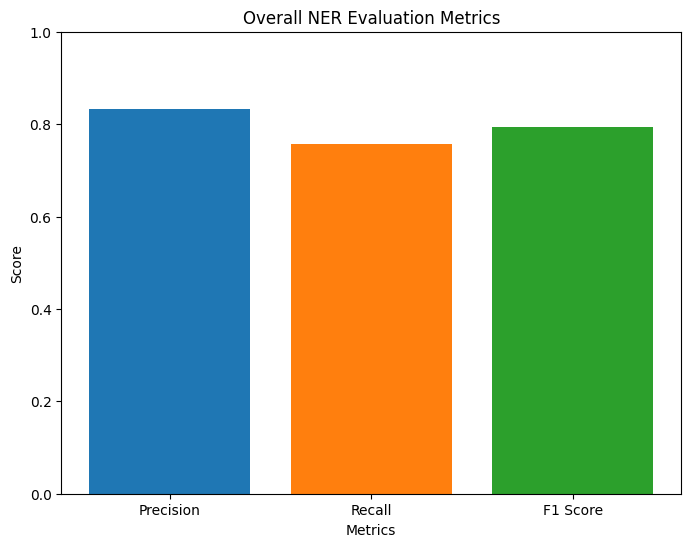

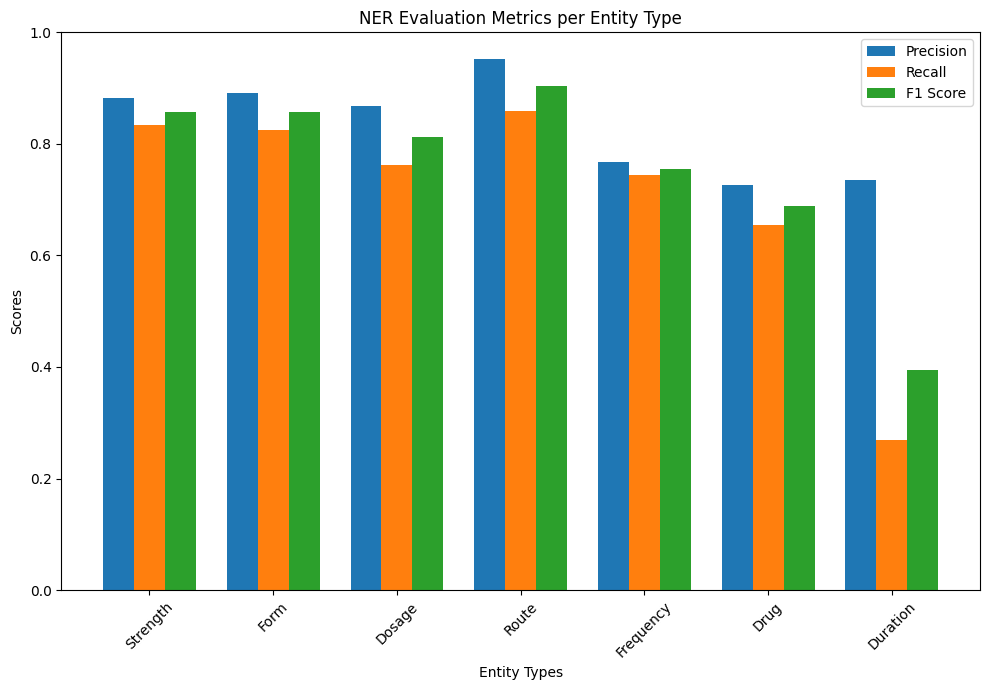

In [46]:
#visualize results

metrics = ['Precision', 'Recall', 'F1 Score']
values = [scorer['ents_p'], scorer['ents_r'], scorer['ents_f']]

#create a bar chart for overall evaluation metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Overall NER Evaluation Metrics')
plt.ylim(0, 1)
plt.show()

ents_per_type = scorer['ents_per_type']
entity_types = list(ents_per_type.keys())
precisions = [ents_per_type[ent]['p'] for ent in entity_types]
recalls = [ents_per_type[ent]['r'] for ent in entity_types]
f1_scores = [ents_per_type[ent]['f'] for ent in entity_types]

#create a bar plot for precision, recall, and F1 score per entity type
x = np.arange(len(entity_types))
width = 0.25
plt.figure(figsize=(10, 7))
plt.bar(x - width, precisions, width, label='Precision', color='#1f77b4')
plt.bar(x, recalls, width, label='Recall', color='#ff7f0e')
plt.bar(x + width, f1_scores, width, label='F1 Score', color='#2ca02c')
plt.xlabel('Entity Types')
plt.ylabel('Scores')
plt.title('NER Evaluation Metrics per Entity Type')
plt.xticks(x, entity_types, rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()